In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, Subset
import random

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


In [3]:
# The data is in https://drive.google.com/file/d/1n9gjLCxzFe8N2QbHeZkDtswlSdNyJpEs/view?usp=drive_link
test_data = np.load("./test_dataset.npy")
print("Test data shape: ", test_data.shape)

Test data shape:  (4, 320, 256, 256)


In [4]:
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        self.down1 = nn.Sequential(nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())
        self.pool2 = nn.MaxPool2d(2)

        self.middle = nn.Sequential(nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.Conv2d(256, 256, 3, padding=1), nn.ReLU())

        self.up1 = nn.Sequential(nn.ConvTranspose2d(256, 128, 2, stride=2), nn.ReLU())
        self.conv_up1 = nn.Sequential(nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())

        self.up2 = nn.Sequential(nn.ConvTranspose2d(128, 64, 2, stride=2), nn.ReLU())
        self.conv_up2 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        down1 = self.down1(x)
        pool1 = self.pool1(down1)
        down2 = self.down2(pool1)
        pool2 = self.pool2(down2)

        middle = self.middle(pool2)

        up1 = self.up1(middle)
        up1 = torch.cat((up1, down2), dim=1)
        up1 = self.conv_up1(up1)

        up2 = self.up2(up1)
        up2 = torch.cat((up2, down1), dim=1)
        up2 = self.conv_up2(up2)

        return self.final(up2)

In [73]:
#Train the Model
def loss_fn(predicted_noise, true_noise):
    return ((predicted_noise - true_noise) ** 2).mean()

# Define a linear noise schedule
def train(model, dataloader, sparsity, timesteps=1000):

    betas = torch.linspace(1e-4, 0.02, timesteps).to(device)
    alphas = 1 - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999))
    epochs = 500
    losses = []
    for epoch in range(epochs):
        epoch_losses = []
        for images in dataloader:
            images = images.to(device)
            Nx = images.shape[-2]
            Ny = images.shape[-1]

            # Randomly select a timestep
            t = torch.randint(0, timesteps, (images.size(0),1,1,1), device=device).long()

            # Get sparrse measurements
            N = int(Nx * Ny * sparsity)
            nx = torch.randint(0, 256, (N,))
            ny = torch.randint(0, 256, (N,))
            mask = torch.zeros(images.shape[-2:]).to(device)
            mask[nx, ny] = 1
            condition = images * mask

            #Drop condition with a probability of 10%
            r = torch.rand(1).to(device)
            condition *= (r > 0.9)

            # Add noise according to the schedule
            noise = torch.randn_like(images)
            alpha_t_bar = alphas_cumprod[t].view(-1, 1, 1, 1)
            x_t = torch.sqrt(alpha_t_bar) * images + torch.sqrt(1 - alpha_t_bar) * noise

            nomalized_t = t / (timesteps)
            time_step_channel = torch.ones_like(x_t) * nomalized_t
            time_step_channel = time_step_channel.to(device)

            #Add Condition
            x_t_with_conditions = torch.cat((x_t, condition), dim=1)

            #Add timestep channel
            x_t_with_conditions_and_time_step = torch.cat((x_t_with_conditions, time_step_channel), dim=1)
            
            optimizer.zero_grad()
            predicted_noise = model(x_t_with_conditions_and_time_step)
            loss = loss_fn(predicted_noise, noise)
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        average_loss = np.mean(epoch_losses)
        losses.append(average_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {average_loss}")
        if epoch % 100 == 0 and epoch > 0:
            torch.save(model.state_dict(), f'./fixed_output_trained_model_epoch{epoch}.pth')
    # Plot the loss after training
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


    torch.save(model.state_dict(), './trained_model.pth')

In [6]:
class NumpyDataset(Dataset):
    def __init__(self, file_path):
        data = np.load(file_path)
        # Reshape the data to create individual samples
        self.data = data.reshape(-1, 256, 256)
        # Normalize the data to [-1, 1]
        self.data = 2 * (self.data - np.min(self.data)) / (np.max(self.data) - np.min(self.data)) - 1

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        image = np.expand_dims(image, axis=0)  # Add channel dimension
        return torch.tensor(image, dtype=torch.float32)
full_dataset = NumpyDataset("/home/baris/Documents/DDSim/Diffusion-based-Fluid-Super-resolution/data/kf_2d_re1000_256_40seed.npy")

# Select 10% of the dataset
percentage = 1
subset_size = int(percentage * len(full_dataset))
subset_indices = random.sample(range(len(full_dataset)), subset_size)
subset_dataset = Subset(full_dataset, subset_indices)

dataloader = DataLoader(subset_dataset, batch_size=32, shuffle=True)


In [79]:
'''
Reading the pretrained parameters
'''
model = SimpleUNet()
state_dict = torch.load('conditional_models/fixed_output_trained_model_epoch275.pth', map_location=torch.device('cpu'), weights_only=True)
model.load_state_dict(state_dict)
#sparsity = 0.1
model.to(device)
#train(model, dataloader, sparsity)
## The pretrained model is in https://drive.google.com/file/d/16W_aeHeB-yBHSFRfo1ILJh3DbahkUiRT/view?usp=drive_link
#model.to(device)
#model.eval();

SimpleUNet(
  (down1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (middle): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (up1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
  )
  (conv_up1): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3),

In [75]:
torch.save(model.state_dict(), 'conditional_models/fixed_output_trained_model_epoch275.pth')

In [27]:
def denoise(x_t, conditions, model, steps=1000, w=0):
    betas = torch.linspace(1e-4, 0.02, steps).to(device)
    alphas = 1 - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0)
    for t in reversed(range(1, steps+1)):
        # the dimension of x_t should be (batch_size, 1, height, width) and remains the same for all the time steps
        # x_t denotes the noised snapshot
        # Two additional channels are added to x_t: the conditions and the normalized time step
        # The input of the model has therefore 3 channels
        # The output of the model is the predicted noise with a single channel
        # The output of the model is used to calculate the previous step (x_{t-1}) in the backward process of the diffusion model
        assert x_t.shape[1] == 1, f"Error: The channel of x_t != 1."  # Make sure the input is a single channel snapshot
        # Add the conditions to x_t as the second channel
        x_t_with_conditions = torch.cat((x_t, conditions), dim=1) # This is your task. Complete this line of code. Only one line of code is needed
        x_t_without_conditions = torch.cat((x_t, torch.zeros_like(conditions)), dim=1)
        assert x_t_with_conditions.shape[1] == 2, f"Error: The channel of x_t_with_conditions != 2."   
        # Add the normalized time step (normalize by divided by the number of the total steps) as the third channel
        nomalized_t = t / (steps)
        time_step_channel = torch.ones_like(x_t) * nomalized_t
        time_step_channel = time_step_channel.to(device)
        x_t_with_conditions_and_time_step = torch.cat((x_t_with_conditions, time_step_channel), dim=1)
        x_t_without_conditions_with_time_step = torch.cat((x_t_without_conditions, time_step_channel), dim=1)
        assert x_t_with_conditions_and_time_step.shape[1] == 3, f"Error: The channel of x_t_with_conditions_and_time_step != 3."   
        # Calculate the parameters
        alpha_t_bar = alphas_cumprod[t-1]
        beta_t = betas[t-1]
        alpha_t = alphas[t-1]

        # Predict the noise using the model
        with torch.no_grad():
            epsilon_theta_conditional = model(x_t_with_conditions_and_time_step)
            epsilon_theta_unconditional = model(x_t_without_conditions_with_time_step)
        epsilon_theta = epsilon_theta_conditional + w * (epsilon_theta_conditional - epsilon_theta_unconditional)
        # Make sure the output of the model (the predicted noise) has a single channel 
        assert epsilon_theta.shape[1] == 1, "Error: The channel of epsilon_theta != 1."  
        # Calculate the mean of the previous step in the backward process of diffusion model
        mean = (1 / torch.sqrt(alpha_t)) * (x_t - (beta_t / torch.sqrt(1 - alpha_t_bar)) * epsilon_theta)  
        # Add noise for all but the last step (strictly follow the algorithm)
        if t > 1:
            # z = torch.randn_like(x_t).to(device)
            z = torch.randn_like(x_t).to(device)
            x_t = mean + torch.sqrt(beta_t) * z
        else:
            x_t = mean
        
    return x_t

torch.Size([1, 1, 256, 256])
torch.Size([5, 1, 256, 256])


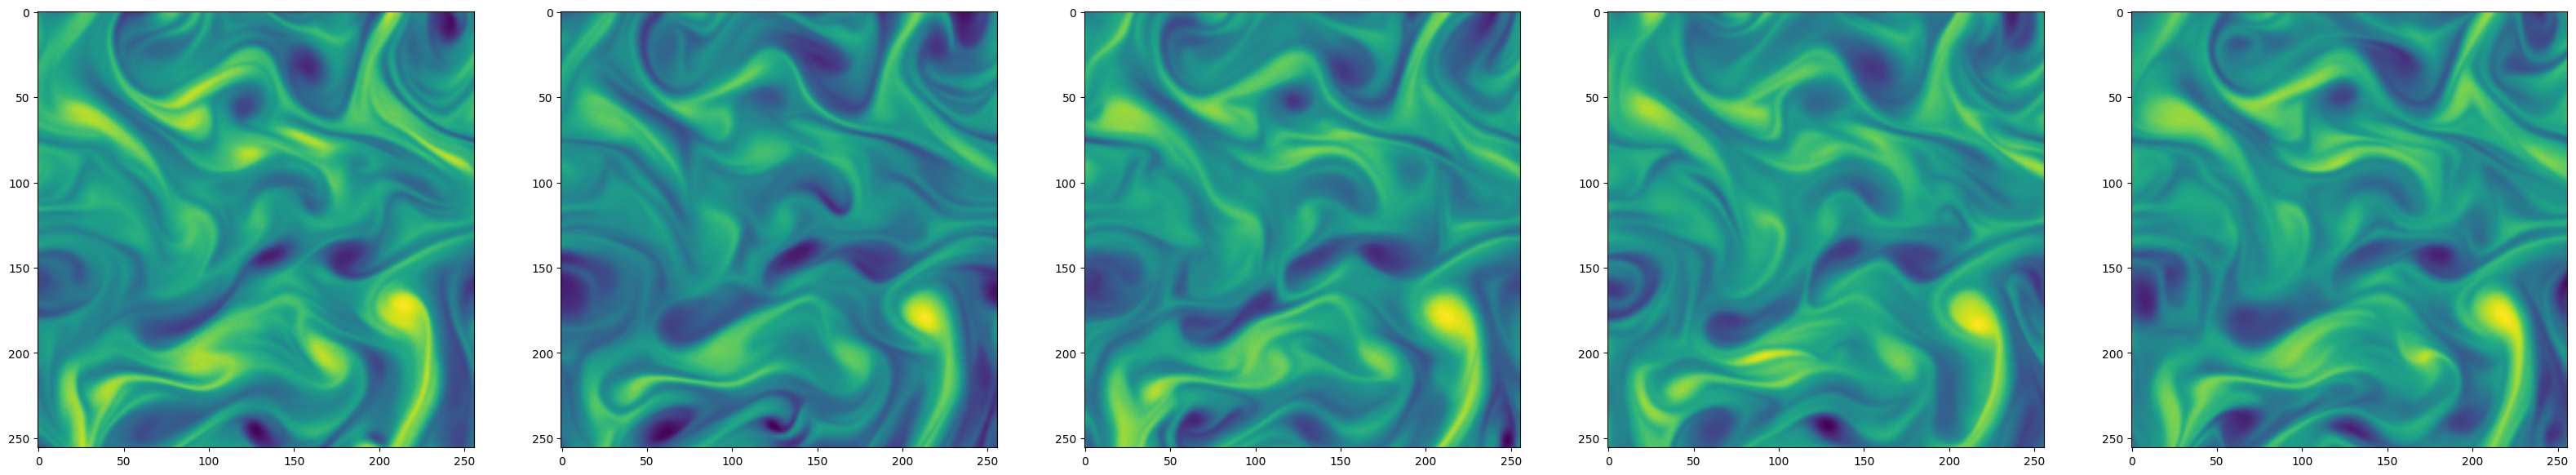

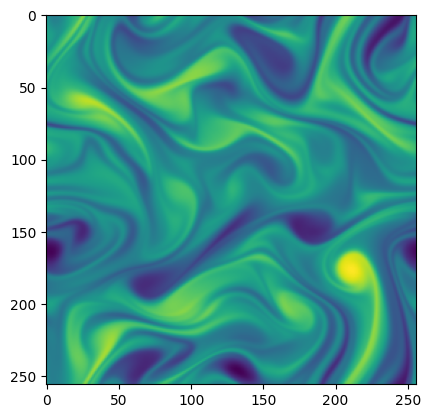

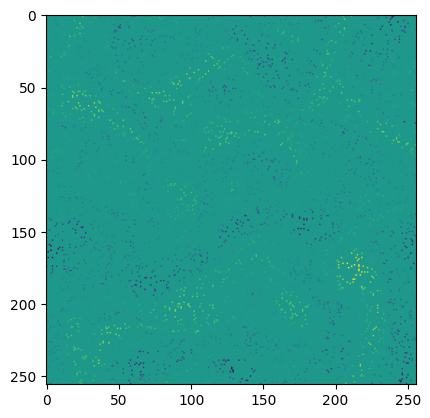

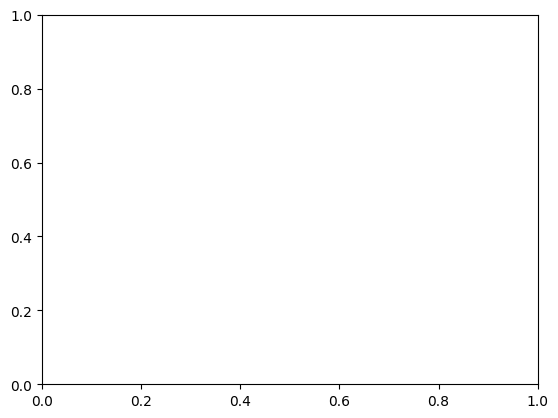

In [80]:

# Choose snapshot from test dataset: [4, 320, 256, 256] by changing the first dimension and the second dimension 
# Make sure that the first and the second dimensions are within the range of the test dataset 
test_snapshot = test_data[1, 110, :, :] # 1 and 110 are chosen here, you change them to get different snapshots

percentage = 6
factor = percentage/100
N = int(256**2 * factor)
test_snapshot = test_data[3, 85, :, :]
nx = np.random.randint(0, 256, (N,))
ny = np.random.randint(0, 256, (N,))
mask = np.zeros_like(test_snapshot)
mask[nx, ny] = 1
masked_snapshot = test_snapshot * mask

#point_indices = np.random.randint(0,256**2, (N,))
#print(point_indices)
#mask = mask.flatten()
#mask[point_indices] = 1
#mask = mask.reshape((256,256))
#masked_snapshot = test_snapshot * mask

sample_noise = torch.randn(5, 1, 256, 256) 
sample_noise = sample_noise.to(device)


# Create the conditions (the second channel to be added in the function "def denoise(x_t, conditions, model, steps=1000):")
conditions = torch.tensor(masked_snapshot, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
print(conditions.shape)
conditions = torch.broadcast_to(conditions, sample_noise.shape)
print(conditions.shape)

# Generate the new samples with conditons
generated_image = denoise(sample_noise, conditions, model, w=0)

fig1, ax1 = plt.subplots(nrows = 1, ncols=5, figsize=(40, 10))
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
fig4, ax4 = plt.subplots()

for i in range(5):
 ax1[i].imshow(generated_image[i].squeeze().cpu())
ax2.imshow(test_snapshot)
ax3.imshow(masked_snapshot)


In [ ]:
# The following code is for visualization and is given for you. You do not need to modify it except making the folder of figures.
plt.figure()
plt.imshow(test_snapshot.squeeze(), origin='lower', vmin=-0.4, vmax=0.4)
plt.title('Conditions for Assimilation')
plt.colorbar(label='Vorticity')
# Plot the square
x_coords = [start_index, start_index, end_endex, end_endex, start_index]  # Close the square by repeating the first point
y_coords = [start_index, end_endex, end_endex, start_index, start_index]  # Close the square by repeating the first point
plt.plot(x_coords, y_coords, color='red', linewidth=2, label='Conditions')
plt.savefig('./figures/conditions_image.png')

plt.figure()
conditions_fig = np.zeros_like(test_snapshot)
conditions_fig[start_index:end_endex, start_index:end_endex] = test_snapshot[start_index:end_endex, start_index:end_endex]
plt.imshow(conditions_fig.squeeze(), origin='lower', vmin=-0.4, vmax=0.4)
plt.title('Conditions for Assimilation')
plt.colorbar(label='Vorticity')
# Plot the square
x_coords = [start_index, start_index, end_endex, end_endex, start_index]  # Close the square by repeating the first point
y_coords = [start_index, end_endex, end_endex, start_index, start_index]  # Close the square by repeating the first point
plt.plot(x_coords, y_coords, color='red', linewidth=2, label='Conditions')
plt.savefig('./figures/conditions.png')


for i in range(generated_image.shape[0]):
    plt.figure()
    plt.imshow(generated_image[i].squeeze().cpu(), origin='lower', vmin=-0.4, vmax=0.4)
    plt.title(f'Generated Flow Field (Sample-{i+1})')
    plt.colorbar(label='Vorticity')
    # Plot the square
    x_coords = [start_index, start_index, end_endex, end_endex, start_index]  # Close the square by repeating the first point
    y_coords = [start_index, end_endex, end_endex, start_index, start_index]  # Close the square by repeating the first point
    plt.plot(x_coords, y_coords, color='red', linewidth=2, label='Conditions')
    plt.savefig(f'./figures/generated_image_{i+1}.png')

In [15]:
torch.save(model.state_dict(), f'./fixed_output_trained_model_epoch116.pth')

(256,)


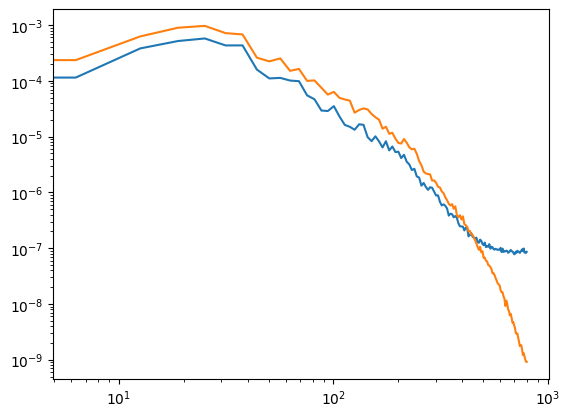

In [81]:
from energy_spectrum import compute_tke_spectrum
_, wavenumbers, spectrum = compute_tke_spectrum(generated_image[0].detach().squeeze().cpu().numpy(),1,1)
fig,ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
print(spectrum.shape)
_, wavenumbers, spectrum_ground_truth = compute_tke_spectrum(test_snapshot,1,1)
ax.plot(wavenumbers[:128], spectrum[:128])
ax.plot(wavenumbers[:128], spectrum_ground_truth[:128])